In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install split-folders

> ## Import libraries

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

import splitfolders
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


> ## Creating A Directory

In [4]:
main_path_dir=('/kaggle/input/')

data_dir=os.path.join(main_path_dir,'psc-image')

for folder in os.listdir(data_dir):
    folder_path=os.path.join(data_dir,folder)
    print(f"Number of images in {folder}:{len(os.listdir(folder_path))}")
    print()

Number of images in Scentless Mayweed:607

Number of images in Common wheat:253

Number of images in Charlock:452

Number of images in Black-grass:309

Number of images in Sugar beet:463

Number of images in Loose Silky-bent:762

Number of images in Maize:257

Number of images in Cleavers:335

Number of images in Common Chickweed:713

Number of images in Fat Hen:538

Number of images in Small-flowered Cranesbill:576

Number of images in Shepherd’s Purse:274



> ## Plotting Image Data

In [5]:
def plot_images(image_dir,num_images):
    images_list=os.listdir(image_dir)
    images_dir_list=[os.path.join(image_dir,image) for image in images_list][:num_images]
    plt.figure(figsize=(10,10))
    plt.suptitle(os.path.split(image_dir)[1])
    for i,image_dir in enumerate(images_dir_list):
        plt.subplot(5,5,i+1)
        img=plt.imread(image_dir)
        plt.imshow(img)
        

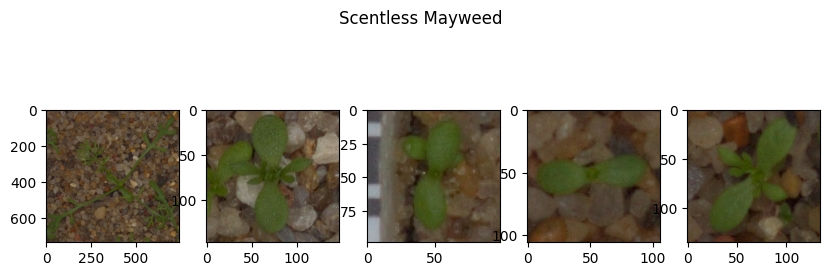

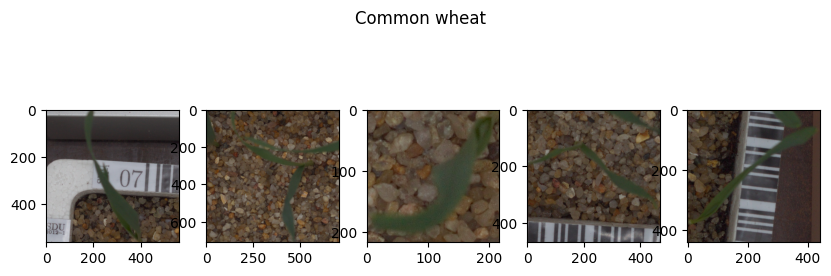

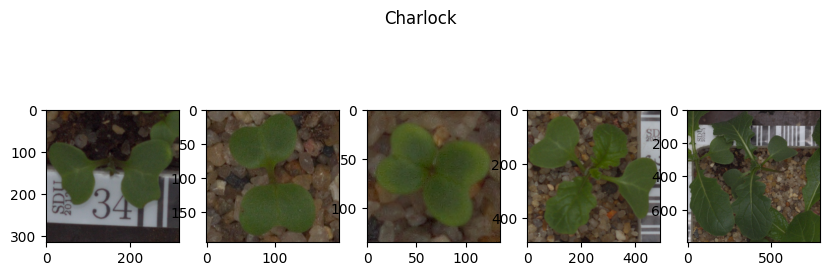

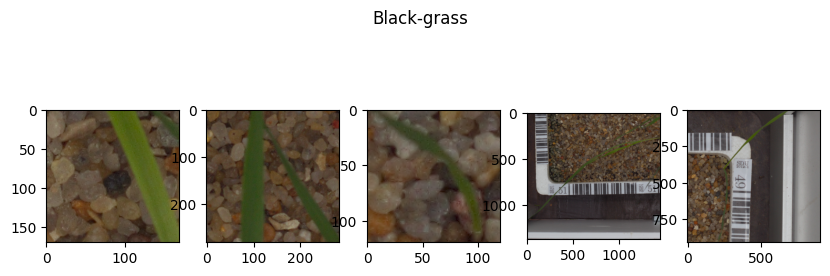

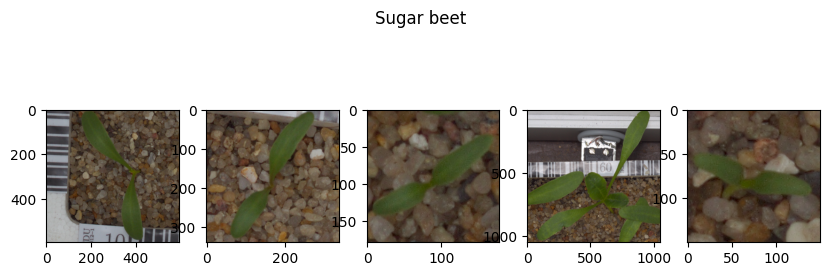

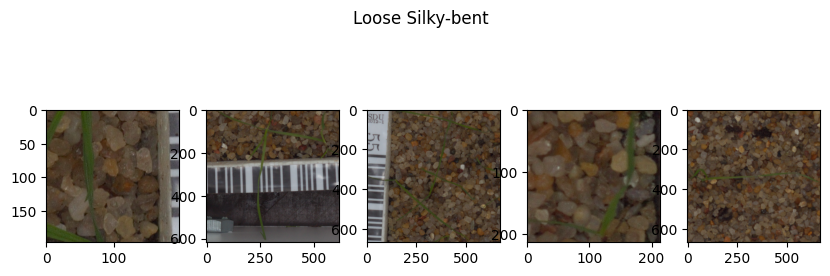

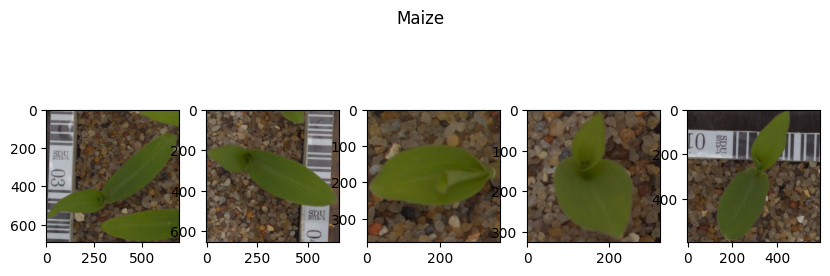

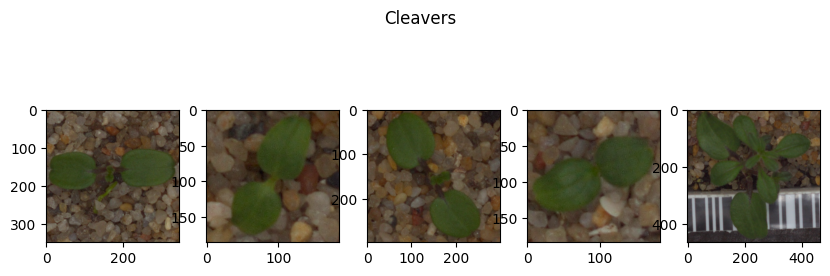

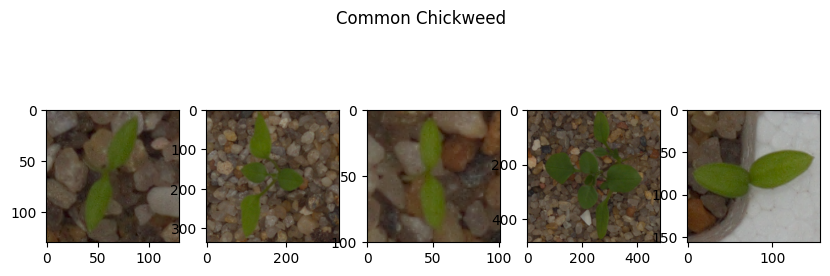

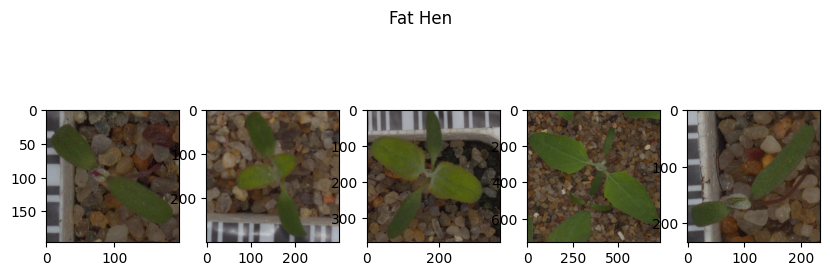

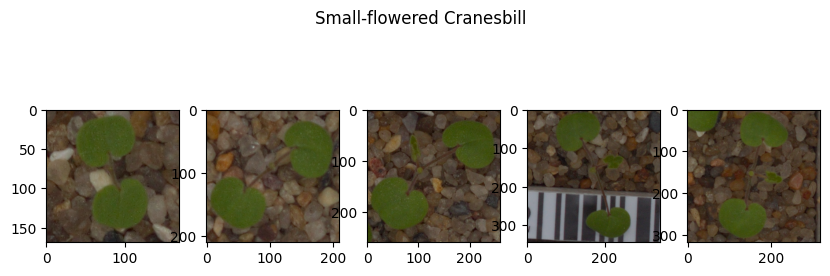

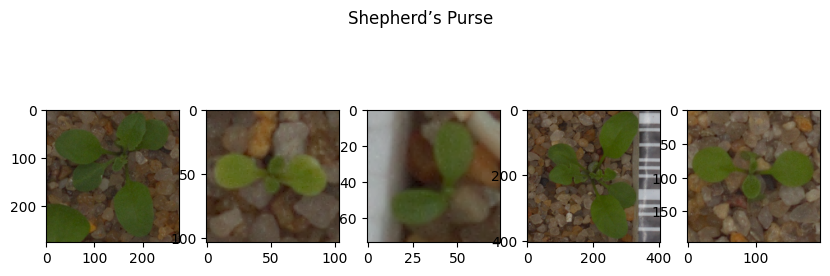

In [6]:
## plotting 5 images from each class
for image_dir in os.listdir(data_dir):
    path=os.path.join(data_dir,image_dir)
    plot_images(path,5)

#### Splitting the Dataset

In [7]:
## Declaration of variable
train_datagen=ImageDataGenerator(rescale=1/255)
valid_datagen=ImageDataGenerator(rescale=1/255)
test_datagen=ImageDataGenerator(rescale=1/255)

#### Creating a directory for train-test-valid dataset

In [8]:
splitfolders.ratio(
    "/kaggle/input/psc-image",
    output="./dataset",
   seed=10,
   ratio=(0.7,0.15, 0.15)
)

Copying files: 5539 files [00:31, 174.47 files/s]


#### Dataset Loading

In [9]:
## loading the train-test-valid data
train_data=train_datagen.flow_from_directory(directory='/kaggle/working/dataset/train',
                                            target_size=(224,224),
                                            batch_size=50)
valid_data=valid_datagen.flow_from_directory(directory='/kaggle/working/dataset/val',
                                            target_size=(224,224),
                                            batch_size=50,
                                            )
test_data=test_datagen.flow_from_directory(directory='/kaggle/working/dataset/test',
                                          target_size=(224,224),
                                          batch_size=50,
                                           shuffle=False)

Found 3872 images belonging to 12 classes.
Found 825 images belonging to 12 classes.
Found 842 images belonging to 12 classes.


> ## Model Building


In [10]:
# function to add the fully-connected layer into my convoltion layer of ResNet50
def prepare_full_model(model,freeze_all,freeze_till,learning_rate):
    if freeze_all:
        for layer in model.layers:
            model.trianable=False
    elif (freeze_till is not None) and (freeze_till>0):
        for layer in model.layers[:-freeze_till]:
            model.trainable=False
        
    flatten_in=tf.keras.layers.Flatten()(model.output)
    
    Dense_layer_1=tf.keras.layers.Dense(units=512,activation='relu')(flatten_in)
    Dropout_layer=tf.keras.layers.Dropout(0.5)(Dense_layer_1)
    Dense_layer_2=tf.keras.layers.Dense(units=256,activation='relu')(Dropout_layer)
    Dense_layer_3=tf.keras.layers.Dense(units=128,activation='relu')(Dense_layer_2)
    Dense_layer_4=tf.keras.layers.Dense(units=64,activation='relu')(Dense_layer_3)
    
    prediction=tf.keras.layers.Dense(units=12,activation='softmax')(Dense_layer_4)

    full_model=tf.keras.models.Model(inputs=model.input,outputs=prediction)

    full_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                           loss=tf.keras.losses.CategoricalCrossentropy(),metrics=['accuracy'])
        
    full_model.summary()
    return full_model

> #### 1.VGG16

In [11]:
model_vgg16=tf.keras.applications.vgg16.VGG16(
    include_top=False,
    input_shape=(224, 224, 3),
    weights='imagenet',classifier_activation='softmax')

58889256/58889256 [==============================] - 3s 0us/step


In [12]:
model=prepare_full_model(model_vgg16,freeze_all=True,freeze_till=None,learning_rate=0.001)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
model.fit(train_data,epochs=25,validation_data=valid_data,verbose=2)

Epoch 1/25
78/78 - 59s - loss: 2.4739 - accuracy: 0.1263 - val_loss: 2.4109 - val_accuracy: 0.1406 - 59s/epoch - 755ms/step
Epoch 2/25
78/78 - 39s - loss: 2.4275 - accuracy: 0.1384 - val_loss: 2.3816 - val_accuracy: 0.2000 - 39s/epoch - 498ms/step
Epoch 3/25
78/78 - 38s - loss: 2.3862 - accuracy: 0.1725 - val_loss: 2.3304 - val_accuracy: 0.1721 - 38s/epoch - 488ms/step
Epoch 4/25
78/78 - 38s - loss: 2.3141 - accuracy: 0.2195 - val_loss: 2.1665 - val_accuracy: 0.2727 - 38s/epoch - 488ms/step
Epoch 5/25
78/78 - 38s - loss: 2.1781 - accuracy: 0.2893 - val_loss: 1.9471 - val_accuracy: 0.3552 - 38s/epoch - 487ms/step
Epoch 6/25
78/78 - 38s - loss: 1.9870 - accuracy: 0.3445 - val_loss: 1.7329 - val_accuracy: 0.4279 - 38s/epoch - 485ms/step
Epoch 7/25
78/78 - 38s - loss: 1.7898 - accuracy: 0.4176 - val_loss: 1.4956 - val_accuracy: 0.4958 - 38s/epoch - 481ms/step
Epoch 8/25
78/78 - 40s - loss: 1.5773 - accuracy: 0.4832 - val_loss: 1.1406 - val_accuracy: 0.6194 - 40s/epoch - 508ms/step
Epoch 9/

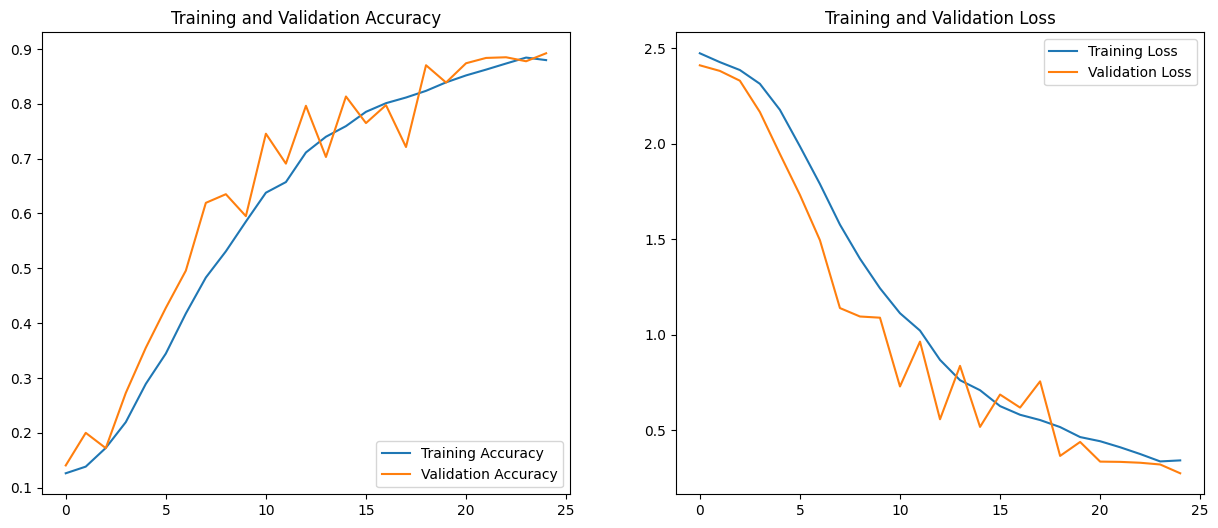

In [19]:
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

epochs_range = range(25)

plt.figure(figsize=(15,6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [20]:
model.predict(test_data,batch_size=25,verbose=2)

17/17 - 10s - 10s/epoch - 578ms/step


array([[2.9261652e-01, 5.9232661e-06, 8.3472725e-04, ..., 7.0891445e-05,
        4.3792985e-05, 4.0062238e-02],
       [9.3095672e-01, 1.9375250e-06, 1.1793674e-04, ..., 3.4339801e-06,
        2.3824705e-05, 2.9947737e-04],
       [7.2944260e-01, 5.0230260e-06, 2.6142565e-04, ..., 2.9644289e-05,
        1.9127213e-04, 8.0010592e-04],
       ...,
       [1.1340036e-07, 1.0229694e-06, 4.5941033e-07, ..., 5.3185076e-08,
        3.2654068e-08, 9.9944013e-01],
       [3.5061153e-06, 3.5210868e-04, 6.6341163e-05, ..., 1.1684358e-06,
        1.5377429e-06, 9.9418890e-01],
       [2.9492984e-04, 5.6930832e-05, 7.7404380e-05, ..., 9.6067579e-06,
        7.7732308e-05, 9.8241490e-01]], dtype=float32)